<a href="https://colab.research.google.com/github/sc0les/nba_prediction_markets/blob/main/WIP_EDA%2C_Model_Selection%2C_and_Model_Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#will need to restart kernal after install
!pip install --pre pycaret

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pycaret.classification import *
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
full_game_df = pd.read_csv('/content/drive/My Drive/Sam Colelli BSTN Capstone/Datasets/full_game_stats.csv', index_col = 0)

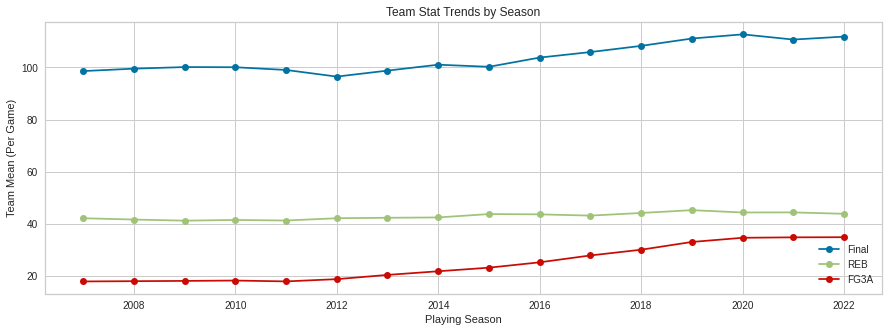

In [ ]:
#team stats by year

stats = full_game_df.groupby(['year'])[['Final', 'REB', 'FG3A']].mean()

plt.figure(figsize = (15,5))
plt.plot(stats, marker = 'o')
plt.xlabel('Playing Season')
plt.ylabel('Team Mean (Per Game)')
plt.title('Team Stat Trends by Season')
plt.legend(stats.columns)
plt.grid
plt.show()

In [ ]:
norm_player = pd.read_csv('/content/drive/My Drive/Sam Colelli BSTN Capstone/Datasets/normalized_player_stats.csv', index_col = 0)
norm_player[['year', 'month', 'day']] = norm_player['GAME_DATE_y'].str.split('-', expand = True)

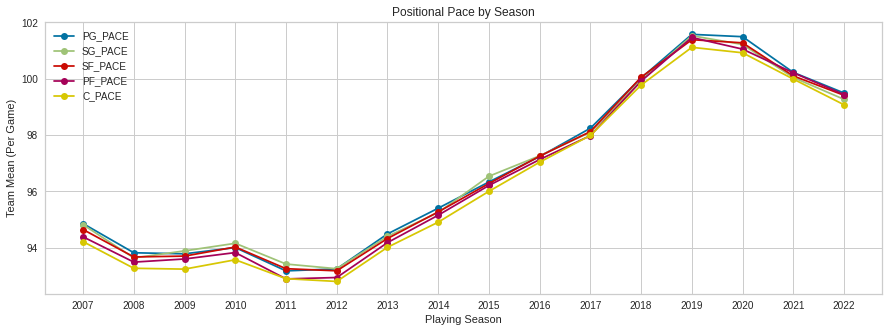

In [ ]:
pace = norm_player.groupby(['year'])[['PG_PACE', 'SG_PACE', 'SF_PACE', 'PF_PACE', 'C_PACE']].mean()

plt.figure(figsize = (15,5))
plt.plot(pace, marker = 'o')
plt.xlabel('Playing Season')
plt.ylabel('Team Mean (Per Game)')
plt.title('Positional Pace by Season')
plt.legend(pace.columns)
plt.grid
plt.show()

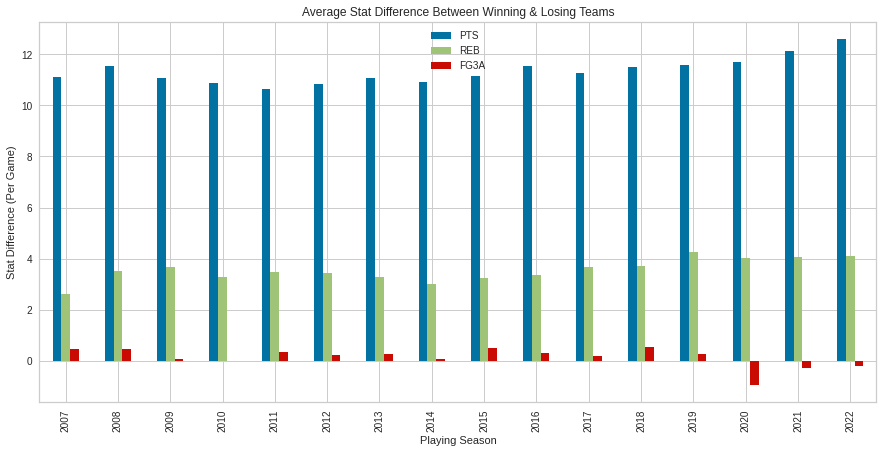

In [ ]:
stats_df = full_game_df.drop(columns = ['GAME_DATE_y', 'home_away'])
stats_win = stats_df[stats_df['WL'] == 'W'].groupby('year')[['PTS', 'REB', 'FG3A']].mean()
stats_loss = stats_df[stats_df['WL'] == 'L'].groupby('year')[['PTS', 'REB', 'FG3A']].mean()
stats_diff = stats_win - stats_loss


stats_diff.plot(kind = 'bar', figsize = (15,7))
plt.xlabel('Playing Season')
plt.ylabel('Stat Difference (Per Game)')
plt.title('Average Stat Difference Between Winning & Losing Teams')
plt.legend(stats_diff.columns)
plt.grid
plt.show()

In [ ]:
full_game_df = pd.read_csv('/content/drive/My Drive/Sam Colelli BSTN Capstone/Datasets/final_nba_df.csv', index_col = 0)

In [ ]:
WL_df = full_df.drop(columns = ['OU_hit', 'spread_hit'])
OU_df = full_df.drop(columns = ['WL_outcome', 'spread_hit'])
SP_df = full_df.drop(columns = ['WL_outcome', 'OU_hit'])

In [ ]:
#leveraging pycart for streamlined model comparison and selection
WL_X = WL_df.iloc[:, :2818].to_numpy()
WL_y = WL_df.iloc[:, 2818:].to_numpy().ravel()

WL_s = setup(WL_X, target = WL_y, use_gpu = True, normalize = True, normalize_method = 'maxabs')

WL_best = compare_models()

print(WL_best)

evaluate_model(WL_best)

In [ ]:
#splitting dataset into test/train split, and then scaling
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

WL_X = WL_df.iloc[:, :2818].to_numpy()
WL_y = WL_df.iloc[:, 2818:].to_numpy().ravel()

WL_X_train, WL_X_test, WL_y_train, WL_y_test = train_test_split(WL_X, WL_y, test_size = 0.25, random_state = 11)

scaler = StandardScaler()
scaler.fit(WL_X_train)
WL_X_train_scaled = scaler.transform(WL_X_train)
WL_X_test_scaled = scaler.transform(WL_X_test)

In [ ]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(solver = 'lbfgs', max_iter = 5000, random_state = 11)
model = lr.fit(WL_X_train_scaled, WL_y_train)

print(f'Train Score: {model.score(WL_X_train_scaled, WL_y_train)}')
print(f'Test Score: {model.score(WL_X_test_scaled, WL_y_test)}')

Train Score: 0.8136537791710206
Test Score: 0.7118077324973877


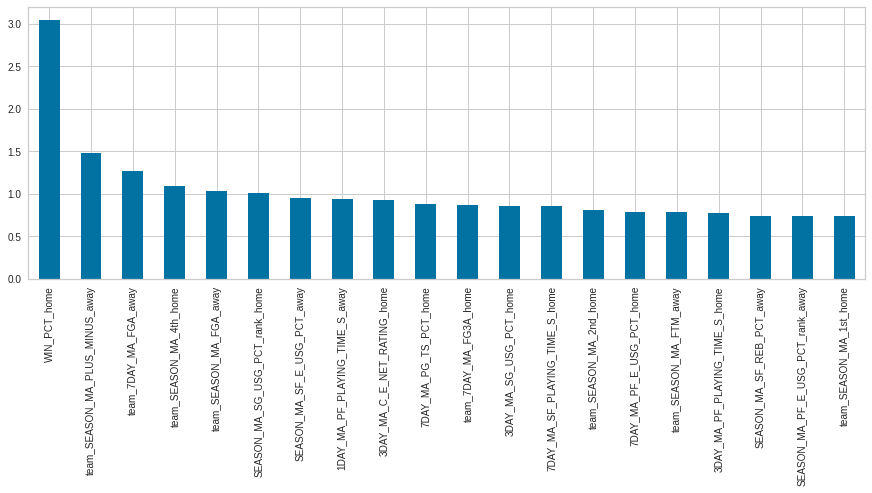

In [ ]:
#visualizing the top features in terms of coefficients
pos_columns = WL_df[WL_df['WL_outcome'] == 1].iloc[:, :2818].columns
test_df = pd.DataFrame({'coefficients': model.coef_[0]}, index = pos_columns).sort_values('coefficients', ascending = False)

test_df.head(20).plot(kind = 'bar', figsize = (15,5), legend = False)
plt.show()

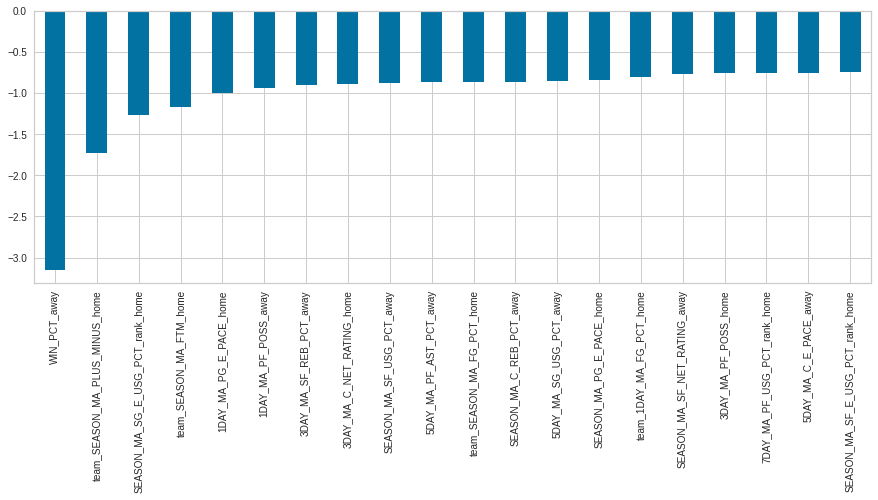

In [ ]:
#visualizing the strongest negative coefficients
neg_columns = WL_df[WL_df['WL_outcome'] == 0].iloc[:, :2818].columns
neg_test_df = pd.DataFrame({'coefficients': model.coef_[0]}, index = neg_columns).sort_values('coefficients', ascending = True)

neg_test_df.head(20).plot(kind = 'bar', figsize = (15,5), legend = False)
plt.show()

In [ ]:
#leveraging PCA due to the size of the dataset
#a coefficient matrix to gauge collinearity would have been too computationally intensive and difficult to analyze
from sklearn.decomposition import PCA

pca_ = PCA()
pca_.fit(WL_X_train_scaled)

X_train_PCA = pca_.transform(WL_X_train_scaled)
X_test_PCA = pca_.transform(WL_X_test_scaled)

<Figure size 432x288 with 0 Axes>

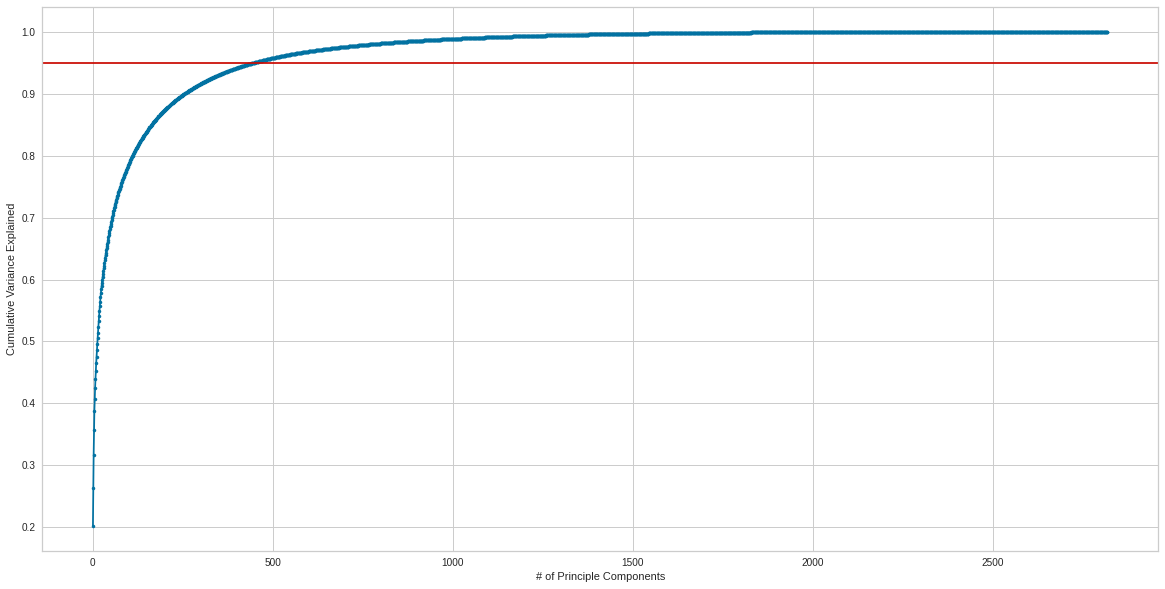

In [ ]:
var_ratio = pca_.explained_variance_ratio_
cum_sum = np.cumsum(var_ratio)

plt.figure()
plt.figure(figsize = (20,10))
plt.plot(range(1,2819), cum_sum, marker = '.')
plt.axhline(0.95, c = 'r')
plt.xlabel('# of Principle Components')
plt.ylabel('Cumulative Variance Explained')
plt.show()

In [ ]:
#due to the drastic decrease in features while maintaning such a high variance preservation, I went with a very high variance to component ratio
pca_ = PCA(n_components = 0.97)
pca_.fit(WL_X_train_scaled)

X_train_PCA = pca_.transform(WL_X_train_scaled)
X_test_PCA = pca_.transform(WL_X_test_scaled)

print(f'Original Feature Set Shape: {WL_X_train_scaled.shape}')
print(f'PCA Transformed Shape: {X_train_PCA.shape}')

Original Feature Set Shape: (14355, 2818)
PCA Transformed Shape: (14355, 620)


In [ ]:
lr = LogisticRegression(solver = 'lbfgs', max_iter = 5000, random_state = 11)
model = lr.fit(X_train_PCA, WL_y_train)

print(f'Train Score: {model.score(X_train_PCA, WL_y_train)}')
print(f'Test Score: {model.score(X_test_PCA, WL_y_test)}')

Train Score: 0.7430163706025775
Test Score: 0.7249738766980146


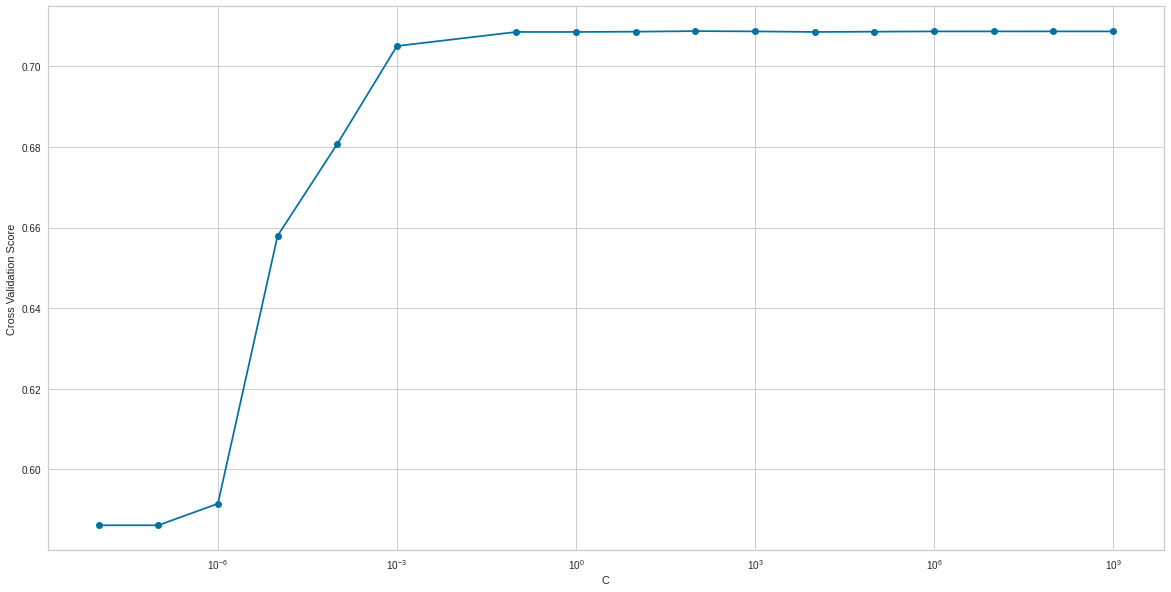

The regularization parameter (C) was the highest model performance is 100.0


In [ ]:
#finding optimal regularization parameter
from sklearn.model_selection import cross_val_score

cv_score_list = []

c_range = np.array (
    [
        0.00000001,
        0.0000001,
        0.000001,
        0.00001,
        0.0001,
        0.001,
        0.1,
        1,
        10,
        100,
        1000,
        10000,
        100000,
        1000000,
        10000000,
        100000000,
        1000000000
    ]
)

for c in c_range:
    cv_logreg = LogisticRegression(C = c, solver = 'lbfgs', max_iter = 5000, random_state = 11)
    cv_score = np.mean(cross_val_score(cv_logreg, X_train_PCA, WL_y_train, cv = 5))
    cv_score_list.append(cv_score)

plt.figure(figsize = (20,10))
plt.plot(c_range, cv_score_list, marker = 'o')
plt.xscale('log')
plt.xlabel('C')
plt.ylabel('Cross Validation Score')
plt.grid
plt.show()

c_max = np.array(cv_score_list).argmax()

print(f'The regularization parameter (C) was the highest model performance is {c_range[c_max]}')

In [ ]:
final_logreg = LogisticRegression(C = c_range[c_max], solver = 'lbfgs', max_iter = 5000, random_state = 11)
final_logreg.fit(X_train_PCA, WL_y_train)
print(f'Train Score: {final_logreg.score(X_train_PCA, WL_y_train)}')
print(f'Test Score: {final_logreg.score(X_test_PCA, WL_y_test)}')

Train Score: 0.7430860327412051
Test Score: 0.7249738766980146


              precision    recall  f1-score   support

           0       0.69      0.62      0.65      1980
           1       0.75      0.80      0.77      2805

    accuracy                           0.72      4785
   macro avg       0.72      0.71      0.71      4785
weighted avg       0.72      0.72      0.72      4785



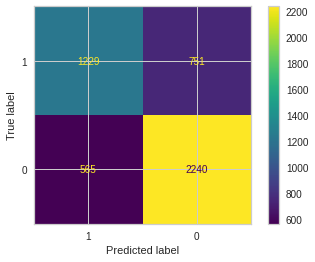

In [ ]:
#better visualizing lr model performance through confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

y_pred = final_logreg.predict(X_test_PCA)
print(classification_report(WL_y_test, y_pred))

y_pred = final_logreg.predict(X_test_PCA)
cm = confusion_matrix(WL_y_test, y_pred)
cols = WL_df['WL_outcome'].unique()
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = cols)
cm_display.plot()
plt.show()

In [ ]:
#going with XGBoost due to its high performance relative to other model alternatives
from xgboost import XGBClassifier

XGB_model = XGBClassifier(random_state = 11)

XGB_model.fit(WL_X_train_scaled, WL_y_train)

XGB_model.score(WL_X_test_scaled, WL_y_test)

0.7362591431556949

In [ ]:
#gauging performance difference between XGBoost and LightGBM considering its speed performance
from lightgbm import LGBMClassifier
from sklearn.metrics import mean_squared_error

lgbm = LGBMClassifier(random_state = 11)
lgbm.fit(WL_X_train_scaled, WL_y_train)
lgbm.score(WL_X_test_scaled, WL_y_test)

0.7345872518286312

In [ ]:
#very slight underperformance compared to XGBoost, but going to continue moving forward with it
#separating dataset further for increased processing speed and to create a validation set
WL_X_sample, WL_X_remainder, WL_y_sample, WL_y_remainder = train_test_split(WL_X, WL_y, test_size = 0.20, random_state = 11)
WL_X_train, WL_X_test, WL_y_train, WL_y_test = train_test_split(WL_X_sample, WL_y_sample, test_size = 0.20, random_state = 11)

scaler = StandardScaler()
scaler.fit(WL_X_train)
WL_X_train_scaled = scaler.transform(WL_X_train)
WL_X_test_scaled = scaler.transform(WL_X_test)
WL_X_remainder_scaled = scaler.transform(WL_X_remainder)

lgbm = LGBMClassifier(random_state = 11)
lgbm.fit(WL_X_train_scaled, WL_y_train)
print(lgbm.score(WL_X_test_scaled, WL_y_test))
print(lgbm.score(WL_X_remainder_scaled, WL_y_remainder))

0.7286973555337904
0.7351097178683386


In [ ]:
#performing GridSearch to identify hyperparameters for LightGBM model
#starting with a wide range of n_estimators and will scale down from there
#if computation was so issue, I'd just perform a larger grid search with granular hyperparameter ranges
from sklearn.model_selection import GridSearchCV

my_lgbm = LGBMClassifier(n_jobs = -1, random_state = 11)

param_grid = {'n_estimators': np.arange(1, 1000, 100), 'max_depth': np.arange(1, 4)}
grid_lgbm = GridSearchCV(my_lgbm, param_grid = param_grid, verbose = 1, n_jobs = -1)

grid_lgbm.fit(WL_X_train_scaled, WL_y_train)
print(f'Train Score: {grid_lgbm.score(WL_X_train_scaled, WL_y_train)}')
print(f'Test Score: {grid_lgbm.score(WL_X_test_scaled, WL_y_test)}')
print(f'Val Score: {grid_lgbm.score(WL_X_remainder_scaled, WL_y_remainder)}')

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Train Score: 0.7496938525593926
Test Score: 0.7306562193927522
Val Score: 0.7309299895506792


In [ ]:
grid_lgbm.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_max_depth', 'param_n_estimators', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])

In [ ]:
#visualizing GridSearch results
results_df = pd.DataFrame({
    'n_estimators': grid_lgbm.cv_results_['param_n_estimators'],
    'max_depth': grid_lgbm.cv_results_['param_max_depth'].astype(str),
    'mean_score': grid_lgbm.cv_results_['mean_test_score']
})

results_df.head()

,n_estimators,max_depth,mean_score
0,1,1,0.590334
1,101,1,0.717038
2,201,1,0.723406
3,301,1,0.725774
4,401,1,0.727652


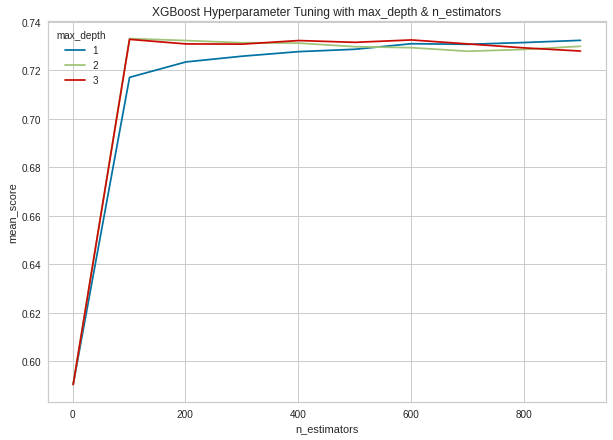

In [ ]:
#visualizing GridSearch results

import seaborn as sns

plt.figure(figsize = (10, 7))
sns.lineplot(x = 'n_estimators', y = 'mean_score', hue = 'max_depth', data = results_df)
plt.title('XGBoost Hyperparameter Tuning')
plt.show()

In [ ]:
grid_lgbm.best_estimator_

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=2,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=101, n_jobs=-1, num_leaves=31, objective=None,
               random_state=11, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
#performing GridSearch again on more granular range of n_estimators after original n_estimators maxed at 
from sklearn.model_selection import GridSearchCV

my_lgbm = LGBMClassifier(n_jobs = -1, random_state = 11)

param_grid = {'n_estimators': np.arange(1, 102, 5), 'max_depth': np.arange(1, 4)}
grid_lgbm = GridSearchCV(my_lgbm, param_grid = param_grid, verbose = 1, n_jobs = -1)

grid_lgbm.fit(WL_X_train_scaled, WL_y_train)
print(f'Train Score: {grid_lgbm.score(WL_X_train_scaled, WL_y_train)}')
print(f'Test Score: {grid_lgbm.score(WL_X_test_scaled, WL_y_test)}')
print(f'Val Score: {grid_lgbm.score(WL_X_remainder_scaled, WL_y_remainder)}')

Fitting 5 folds for each of 63 candidates, totalling 315 fits
Train Score: 0.7496938525593926
Test Score: 0.7306562193927522
Val Score: 0.7309299895506792


In [ ]:
grid_lgbm.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_max_depth', 'param_n_estimators', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])

In [ ]:
#viz of hyperparameters via df
results_df = pd.DataFrame({
    'n_estimators': grid_lgbm.cv_results_['param_n_estimators'],
    'max_depth': grid_lgbm.cv_results_['param_max_depth'].astype(str),
    'mean_score': grid_lgbm.cv_results_['mean_test_score']
})

results_df.head()

,n_estimators,max_depth,mean_score
0,1,1,0.590334
1,6,1,0.619891
2,11,1,0.688219
3,16,1,0.694342
4,21,1,0.700057


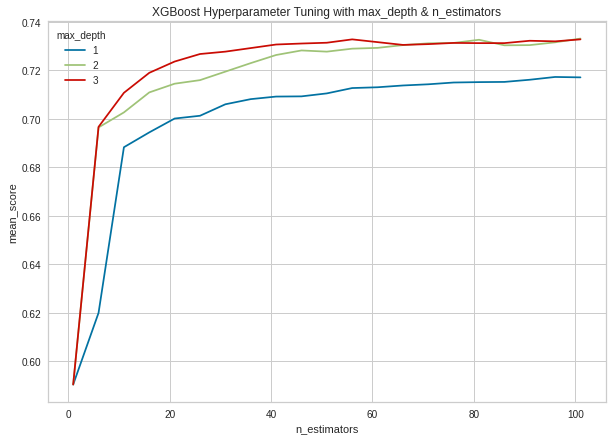

In [ ]:
import seaborn as sns

plt.figure(figsize = (10, 7))
sns.lineplot(x = 'n_estimators', y = 'mean_score', hue = 'max_depth', data = results_df)
plt.title('XGBoost Hyperparameter Tuning')
plt.show()

In [ ]:
grid_lgbm.best_estimator_

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=2,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=101, n_jobs=-1, num_leaves=31, objective=None,
               random_state=11, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
#plugging optimal hyperparameters into model

WL_X = WL_df.iloc[:, :2818].to_numpy()
WL_y = WL_df.iloc[:, 2818:].to_numpy().ravel()

WL_X_train, WL_X_test, WL_y_train, WL_y_test = train_test_split(WL_X, WL_y, test_size = 0.25, random_state = 11)

scaler = StandardScaler()
scaler.fit(WL_X_train)
WL_X_train_scaled = scaler.transform(WL_X_train)
WL_X_test_scaled = scaler.transform(WL_X_test)

lgbm = LGBMClassifier(n_estimators = 101, max_depth = 2, random_state = 11)
lgbm.fit(WL_X_train_scaled, WL_y_train)
print(lgbm.score(WL_X_test_scaled, WL_y_test))

0.7341692789968652


In [ ]:
#plugging optimal hyperparameters for LightGBM into XGBoost, just to see if theres a performance boost

WL_X = WL_df.iloc[:, :2818].to_numpy()
WL_y = WL_df.iloc[:, 2818:].to_numpy().ravel()

WL_X_train, WL_X_test, WL_y_train, WL_y_test = train_test_split(WL_X, WL_y, test_size = 0.25, random_state = 11)

scaler = StandardScaler()
scaler.fit(WL_X_train)
WL_X_train_scaled = scaler.transform(WL_X_train)
WL_X_test_scaled = scaler.transform(WL_X_test)

xgb = XGBClassifier(n_estimators = 101, max_depth = 2, random_state = 11)
xgb.fit(WL_X_train_scaled, WL_y_train)
print(xgb.score(WL_X_test_scaled, WL_y_test))

0.7337513061650993
